In [0]:
import re
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) 
stop_words.add("hotel")
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('averaged_perceptron_tagger')
from nltk import FreqDist
import spacy
import gensim
from gensim import models
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
data=pd.read_csv("/content/drive/My Drive/NLP/Project/Input/Datafiniti_Hotel_Reviews_Jun19.csv", encoding='utf8')
data

,id,dateAdded,dateUpdated,address,categories,primaryCategories,city,country,keys,latitude,longitude,name,postalCode,province,reviews.date,reviews.dateAdded,reviews.dateSeen,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sourceURLs,websites
0,AWE2FvX5RxPSIh2RscTK,2018-01-18T18:43:12Z,2019-05-20T23:55:47Z,5620 Calle Real,"Hotels,Hotels and motels,Hotel and motel mgmt....",Accommodation & Food Services,Goleta,US,us/ca/goleta/5620callereal/-1127060008,34.441780,-119.819790,Best Western Plus South Coast Inn,93117,CA,2018-01-01T00:00:00.000Z,NaN,2018-01-03T00:00:00Z,3,https://www.tripadvisor.com/Hotel_Review-g3243...,"This hotel was nice and quiet. Did not know, t...",Best Western Plus Hotel,San Jose,UnitedStates,tatsurok2018,https://www.tripadvisor.com/Hotel_Review-g3243...,https://www.bestwestern.com/en_US/book/hotel-r...
1,AVwcj_OhkufWRAb5wi9T,2016-11-06T20:21:05Z,2019-05-20T23:31:56Z,5th And San Carlos PO Box 3574,"Hotels,Lodging,Hotel",Accommodation & Food Services,Carmel by the Sea,US,us/ca/carmelbythesea/5thandsancarlospobox3574/...,36.557220,-121.921940,Best Western Carmel's Town House Lodge,93921,CA,2016-04-02T00:00:00Z,NaN,2016-10-09T00:00:00Z,4,https://www.tripadvisor.com/Hotel_Review-g3217...,We stayed in the king suite with the separatio...,Clean rooms at solid rates in the heart of Carmel,San Francisco,CA,STEPHEN N,http://www.tripadvisor.com/Hotel_Review-g32172...,http://www.bestwestern.com
2,AVwcj_OhkufWRAb5wi9T,2016-11-06T20:21:05Z,2019-05-20T23:31:56Z,5th And San Carlos PO Box 3574,"Hotels,Lodging,Hotel",Accommodation & Food Services,Carmel by the Sea,US,us/ca/carmelbythesea/5thandsancarlospobox3574/...,36.557220,-121.921940,Best Western Carmel's Town House Lodge,93921,CA,2016-01-06T00:00:00Z,NaN,2016-10-09T00:00:00Z,3,https://www.tripadvisor.com/Hotel_Review-g3217...,"Parking was horrible, somebody ran into my ren...",Business,Prescott Valley,AZ,15Deborah,http://www.tripadvisor.com/Hotel_Review-g32172...,http://www.bestwestern.com
3,AVwcj_OhkufWRAb5wi9T,2016-11-06T20:21:05Z,2019-05-20T23:31:56Z,5th And San Carlos PO Box 3574,"Hotels,Lodging,Hotel",Accommodation & Food Services,Carmel by the Sea,US,us/ca/carmelbythesea/5thandsancarlospobox3574/...,36.557220,-121.921940,Best Western Carmel's Town House Lodge,93921,CA,2016-08-22T00:00:00Z,NaN,2016-10-31T00:00:00Z,5,https://www.tripadvisor.com/Hotel_Review-g3217...,Not cheap but excellent location. Price is som...,Very good,Guaynabo,PR,Wilfredo M,http://www.tripadvisor.com/Hotel_Review-g32172...,http://www.bestwestern.com
4,AVwcj_OhkufWRAb5wi9T,2016-11-06T20:21:05Z,2019-05-20T23:31:56Z,5th And San Carlos PO Box 3574,"Hotels,Lodging,Hotel",Accommodation & Food Services,Carmel by the Sea,US,us/ca/carmelbythesea/5thandsancarlospobox3574/...,36.557220,-121.921940,Best Western Carmel's Town House Lodge,93921,CA,2016-03-21T00:00:00Z,NaN,"2016-10-09T00:00:00Z,2016-03-27T00:00:00Z",2,https://www.tripadvisor.com/Hotel_Review-g3217...,If you get the room that they advertised on th...,Low chance to come back here,Reno,NV,Luc D,http://www.tripadvisor.com/Hotel_Review-g32172...,http://www.bestwestern.com
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,AVwdatg0ByjofQCxo5S5,2017-04-14T05:04:33Z,2018-12-02T13:36:35Z,3101 Coliseum Dr,"Hotels,Hotels and motels,Corporate Lodging,New...",Accommodation & Food Services,Hampton,US,us/va/hampton/3101coliseumdr/-1319580369,37.057650,-76.393310,Hampton Inn Hampton-newport News,23666,VA,2015-12-24T00:00:00Z,NaN,"2016-03-16T00:00:00Z,2016-04-03T00:00:00Z",4,http://www.tripadvisor.com/Hotel_Review-g57804...,My friends and I took a trip to Hampton for th...,Very accommodating and friendly staff!,Wallingford,CT,Tiffany1017,https://www.tripadvisor.com/Hotel_Review-g5780...,https://ad.doubleclick.net/ddm/clk/317271033;1...
9996,AVwdatg0ByjofQCxo5S5,2017-04-14T05:04:33Z,2018-12-02T13:36:35Z,3101 Coliseum Dr,"Hotels,Hotel

In [0]:
#due to the low speed select a small sample
RT_data=data[0:70].copy()

In [0]:
word_embeddings = {}
f= open("/content/drive/My Drive/NLP/Project/Input/twiglove/glove.twitter.27B.100d.txt",encoding="utf-8")
for line in f:
  values=line.split()
  word=values[0]
  coefs=np.asarray(values[1:],dtype="float32")
  word_embeddings[word]=coefs
f.close()
#GloVe word vector is a vector representation of words. 
#These word vectors will be used to generate feature vectors representing sentences. 
#We can also use Bag-of-Words or TF-IDF methods to generate features for sentences, 
#but these methods ignore the order of words, and usually the number of these features is very large.

In [0]:
class rank_text():
  def __init__(self,word_embeddings):
    self.word_embeddings=word_embeddings

  def clean_text(self,croup):
    x=word_tokenize(croup)
    clean_senteces=pd.Series(x).str.replace("[^a-zA-Z]"," ")
    clean_senteces=[s.lower() for s in clean_senteces]
    text_no_sp=[]
    for r in clean_senteces:
      tmp=r.split()
      #print(tmp)
      sen_new=" ".join([i for i in tmp if i not in stop_words ])
      text_no_sp.append(sen_new)
    return(text_no_sp)

    
  def sent_vect(self,clean_senteces):
    sentence_vector=[]
    for i in clean_senteces:
      if len(i)!=0:
        v=sum([self.word_embeddings.get(w,np.zeros((100,)))for w in i.split()])/(len(i.split())+0.001)
      else:
        v=np.zeros((100,))
      sentence_vector.append(v)
    return sentence_vector
  def rank_text(self,org_sent,sentence_vector,n_word):
    s=word_tokenize(org_sent)
    sim_mat=np.zeros([len(s),len(s)])
    
    #print(len(s))
    for i in range (len(s)):
      for j in range(len(s)):
        if i!=j:
          sim_mat[i][j]=cosine_similarity(sentence_vector[i].reshape(1,100),sentence_vector[j].reshape(1,100))[0,0]
    nx_graph=nx.from_numpy_array(sim_mat)
    score=nx.pagerank(nx_graph)
    ranked_sentences=sorted(((score[i],s)for i,s in enumerate(s)),reverse=True)
    wl=[]
    for i in range(n_word):
      wl.append(ranked_sentences[i][1])
    return wl
    rt=rank_text(word_embeddings)
rank_list=[]
rt=rank_text(word_embeddings)
for i in RT_data['reviews.text']:
  if len(sent_tokenize(i))>1:
    #sk=sk_TF()
    clean=rt.clean_text(i)
    #print(clean)
    s_vt=rt.sent_vect(clean)
    #print(s_vt)
    word=rt.rank_text(i,s_vt,5)
    rank_list.append(word)
  else:
    rank_list.append(["NA"])

In [0]:
!pip install summa
from summa import keywords
from nltk.stem import PorterStemmer 
ps = PorterStemmer() 
rank_summa=[]
for i in RT_data['reviews.text']:
  words = word_tokenize(i) 
  t=[]
  for w in words:
    t.append(ps.stem(w))
  s=" ".join(t)
  if len(sent_tokenize(s))>1:
    x=keywords.keywords(s)
    x=x.split("\n")
    rank_summa.append(x)
  else:
    rank_summa.append("NA")
#print(rank_list)


In [0]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
class sk_TF():
  def __init__(self):
    self.vectorizer = TfidfVectorizer(ngram_range=(1, 1))

  def clean_text(self,croup):
    x=sent_tokenize(croup)
    clean_senteces=pd.Series(x).str.replace("[^a-zA-Z]"," ")
    clean_senteces=pd.Series(x).str.replace("�"," ")

    clean_senteces=[s.lower() for s in clean_senteces]
    text_no_sp=[]
    for r in clean_senteces:
      tmp=r.split()
      sen_new=" ".join([i for i in tmp if i not in stop_words ])
      text_no_sp.append(sen_new)
    return(text_no_sp)
  def get_topic(self,clean_senteces):

    X = self.vectorizer.fit_transform(clean_senteces)
    terms = self.vectorizer.get_feature_names()
    n_pick_topics =   1            # 设定主题数为1
    lsa = TruncatedSVD(n_pick_topics)               
    X2 = lsa.fit_transform(X)
    n_pick_keywords = 5
    topic_keywords_id = [lsa.components_[t].argsort()[:-(n_pick_keywords+1):-1] for t in range(n_pick_topics)]
    if np.size(terms) < n_pick_keywords:
      for t in range(n_pick_topics):
        topic=" ".join(terms[topic_keywords_id[t][j]] for j in range(np.size(terms)))
    else:
      for t in range(n_pick_topics):
        topic=" ".join(terms[topic_keywords_id[t][j]] for j in range(n_pick_keywords))
    return topic.split()
sk=sk_TF()
tf_list=[]
for i in RT_data['reviews.text']:
  if len(i.split())>10:
    #sk=sk_TF()
    t=sk.clean_text(i)
    #print(t)
    x=sk.get_topic(t)
    #print(x)
    tf_list.append(x)
  else:
    tf_list.append(" ")
  

In [0]:
import functools
import operator
flat_tf = functools.reduce(operator.iconcat, tf_list, [])


flat_rk = functools.reduce(operator.iconcat, rank_list, [])
flat_su = functools.reduce(operator.iconcat, rank_summa, [])


In [0]:
RT_data["TF"]=tf_list
RT_data["TR"]=rank_list
RT_data["SU"]=rank_summa
RT_data[["TF","TR","SU"]].head(20)

,TF,TR,SU
0,"[train, stay, passed, track, near]","[know, Best, near, nice, track]","[hotel wa, train]"
1,"[king, bed, clean, comfortable, room]","[room, left, living, bed, bed]","[stay, night, space]"
2,"[there, staying, car, somebody, rental]","[get, room, try, business, business]","[horribl, somebodi]"
3,"[excellent, cheap, location, service, personnel]","[Front, room, good, service, offer]","[excel locat, price]"
4,"[stay, rooms, two, probably, one]","[get, get, rooms.Nobody, many, one-two]","[room, rooms, noisi, smelli]"
5,"[trying, menu, hard, vibrant, vibe]","[trying, fun, hard, Loved, lovely]","[love, fluffi towel, hip]"
6,"[elevators, waited, routinely, minutes, 10]","[would, room, Everything, stayed, friends]","[recent stay, thi]"
7,"[room, numbers, phone, confirmation, given]","[great, room, room, given, usually]","[room, confirm]"
8,,[NA],NA
9,"[horrible, place, omg, kill, movies]","[ever, one, place, place, place]","[thi, place]"


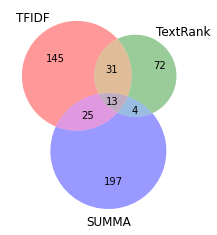

In [0]:
from matplotlib import pyplot as plt
from matplotlib_venn import venn3, venn3_circles
set1 = set(flat_tf)
set2 = set(flat_rk)
set3 = set(flat_su)
venn3([set1, set2, set3], ('TFIDF', 'TextRank', 'SUMMA'))
plt.show()